In [13]:
import pandas as pd
import numpy as np
import random

from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, RandomizedSearchCV, train_test_split

from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import lightgbm as lgb
import os

In [14]:
train = pd.read_csv("../03-data-creation/train_FE.csv")
test = pd.read_csv("../03-data-creation/test_FE.csv")

# Drop unwanted column
train = train.drop("Unnamed: 0", axis = 1)
test = test.drop("Unnamed: 0", axis = 1)

# We won't touch test until predicting for submission

# We don't want the ID to be used in the model so preserve
train_id = train['id']
test_id = test['id']

train = train.drop('id', axis = 1)
test = test.drop('id', axis = 1)

# Split X and y
X = train.loc[:, train.columns != "satisfied"]
y = train.satisfied

In [15]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 3096)

In [16]:
# Fit model - default params
model = lgb.LGBMClassifier()
model.fit(X_train, y_train)
print(); print(model)


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


In [17]:
# Predict
expected_y = y_test
predicted_y = model.predict(X_test)

# Summarize model fit
print(); print(metrics.classification_report(expected_y, predicted_y))
print(); print(metrics.confusion_matrix(expected_y, predicted_y))
print(); print(metrics.roc_auc_score(expected_y, predicted_y))


              precision    recall  f1-score   support

           0       0.80      0.79      0.79      2824
           1       0.82      0.82      0.82      3192

    accuracy                           0.81      6016
   macro avg       0.81      0.81      0.81      6016
weighted avg       0.81      0.81      0.81      6016


[[2229  595]
 [ 562 2630]]

0.8066203930506153


Hyperparameter tuning:

In [18]:
# Hyperparameter grid
param_grid = {
    'boosting_type': ['gbdt'], 
    'n_estimators': list(range(50,2000)),
    'num_leaves': list(range(20, 100)),
    'learning_rate': list(np.logspace(np.log10(0.005), np.log10(0.5), base = 10, num = 1000)),
    'subsample_for_bin': list(range(20000, 300000, 20000)),
    'min_child_samples': list(range(20, 500, 5)),
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    'colsample_bytree': list(np.linspace(0.6, 1, 10)),
    'subsample': list(np.linspace(0.5, 1, 100)),
    'objective': ['binary'],
    'metric': ['auc'],
    'is_unbalance': [False]
}

In [19]:
rsearch = RandomizedSearchCV(estimator = model,
                             param_distributions = param_grid,
                             n_iter = 50,
                             verbose = 10,
                             cv = 5,
                             n_jobs = -1,
                             scoring = 'roc_auc')

rsearch.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 13.7min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 16.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 18.3min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 21

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=LGBMClassifier(boosting_type='gbdt',
                                            class_weight=None,
                                            colsample_bytree=1.0,
                                            importance_type='split',
                                            learning_rate=0.1, max_depth=-1,
                                            min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=100, n_jobs=-1,
                                            num_leaves=31, objective=None,
                                            random_state=None, reg_alpha=0.0,
                                            reg_lambda=0.0, sile...
                                                      0.6161616161616161,
                                                   

In [20]:
print(rsearch.best_params_)

{'subsample_for_bin': 140000, 'subsample': 0.8484848484848485, 'reg_lambda': 0.7346938775510203, 'reg_alpha': 0.4897959183673469, 'objective': 'binary', 'num_leaves': 81, 'n_estimators': 962, 'min_child_samples': 305, 'metric': 'auc', 'learning_rate': 0.010897034921514772, 'is_unbalance': False, 'colsample_bytree': 0.6444444444444444, 'boosting_type': 'gbdt'}


In [21]:
#Prediction
y_pred = rsearch.predict(X_test)

#auc calculation
metrics.roc_auc_score(y_test,y_pred)

0.8125177497568283

Text(0, 0.5, 'Feature Importance Score')

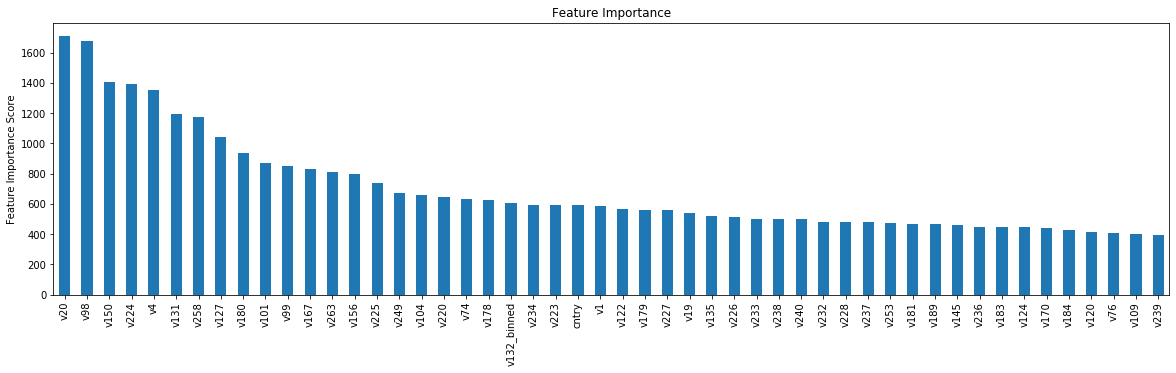

In [22]:
#Feature importance for top 50 predictors
predictors = [x for x in X_train.columns]
feat_imp = pd.Series(rsearch.best_estimator_.feature_importances_, predictors).sort_values(ascending=False)
feat_imp = feat_imp[0:50]
plt.rcParams['figure.figsize'] = 20, 5
feat_imp.plot(kind='bar', title='Feature Importance')
plt.ylabel('Feature Importance Score')

In [ ]:
# Gridsearch around the optimal params

## FOR SUBMISSION ONLY:

In [26]:
# Now fit LGBM on full training data
# model_full = lgb.LGBMClassifier(**rsearch.best_params_)
# model_full.fit(X, y)
# print(); print(model)


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


In [28]:
submit = test.copy()
submit['Predicted'] = rsearch.predict(test)

In [29]:
submit['id'] = test_id

In [30]:
submit[['id', 'Predicted']].to_csv('lgb_submission_2.csv', index = False, float_format = "%.8f")